## Pêndulo invertido com compensador - projeto de um observador de ordem reduzida

Modelo matemático extraído de:

Friedland, B. (2012). *Control System Design: An Introduction to State-Space Methods.* Estados Unidos: Dover Publications.

![PENDULO_INV](db_pend_inv.png)

In [1]:
# !pip install sympy
# !pip install control

In [2]:
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt
import control as ct

In [3]:
# Paleta de cores
cp = {
    'red': (1.0, 0.349, 0.369, 1.0),
    'green': (0.541, 0.788, 0.149, 1.0),
    'blue': (0.098, 0.510, 0.769, 1.0),
    'lred': (1.0, 0.588, 0.6, 1.0),
    'lgreen': (0.722, 0.894, 0.443, 1.0),
    'lblue': (0.369, 0.706, 0.918, 1.0),
    'dred': (0.839,0.0,0.027),
    'dgreen': (0.341,0.494,0.094),
    'dblue': (0.063,0.318,0.475),
    'orange': (1.0, 0.506, 0.227, 1.0),
    'yellow': (1.0, 0.792, 0.227, 1.0),
    'pink': (1.0, 0.349, 0.611, 1.0),
    'purple': (0.416, 0.298, 0.576, 1.0),
    'turquoise': (0.098, 0.761, 0.769, 1.0),
    'brown': (0.576, 0.380, 0.298, 1.0)
}

### 1 - Sistema na forma de espaço de estados

In [4]:
# dimensões do modelo
n = 3 # variáveis de estado
r = 1 # entradas de controle
l = 1 # entradas de distúrbio
m = 1 # saídas

In [5]:
# parâmetros
ω_p = 1.0 # frequência natural do pêndulo
ω_c = 2.5 # frequência adotada para o compensador

In [6]:
A = np.array([[0, 1, 0],
                [ω_p**2, 0, -1],
                [0, 0, 0]])


B = np.array([[0], [1], [ω_c]])

C = np.array([[1, 0, 0]])

D = np.array([[0]])

E = np.array([[0], [1], [0]])

In [7]:
inv_pend = ct.ss(A, B, C, D)
inv_pend

<LinearIOSystem:sys[2]:['u[0]']->['y[0]']>

Uma vez que a matriz $C$ corresponde à primeira linha da matriz identidade 3x3, a matriz $V$ pode ser tomada como a matriz às outras duas linhas, tornando assim a matriz $T$ uma identidade, não sendo necessário efetuar qualquer mudança de variáveis para o projeto do observador de ordem reduzida.

In [8]:
V = np.eye(3)[m:, :]  # ou no caso mais geral, use V = la.null_space(C).T
T = np.block([[C], [V]])
Ti = la.inv(T)
Ti

array([[ 1.,  0., -0.],
       [ 0.,  1., -0.],
       [ 0.,  0.,  1.]])

In [9]:
M = Ti[:, 0:m]
M

array([[1.],
       [0.],
       [0.]])

In [10]:
N = Ti[:, m:]
N

array([[ 0., -0.],
       [ 1., -0.],
       [ 0.,  1.]])

In [11]:
A11 = C @ A @ M
A11

array([[0.]])

In [12]:
A12 = C @ A @ N
A12

array([[1., 0.]])

In [13]:
A21 = V @ A @ M
A21

array([[1.],
       [0.]])

In [14]:
A22 = V @ A @ N
A22

array([[ 0., -1.],
       [ 0.,  0.]])

In [15]:
B1 = C @ B
B1

array([[0.]])

In [16]:
B2 = V @ B
B2

array([[1. ],
       [2.5]])

### 2 - Testes de Controlabilidade e Observabilidade

In [17]:
# matriz de controlabilidade 
Ctb = ct.ctrb(A, B)
Ctb

array([[ 0. ,  1. , -2.5],
       [ 1. , -2.5,  1. ],
       [ 2.5,  0. ,  0. ]])

In [18]:
# posto da matriz de controlabilidade
np.linalg.matrix_rank(Ctb)

3

In [19]:
# matriz de observabilidade
Obs = ct.obsv(A, C)
Obs

array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 1.,  0., -1.]])

In [20]:
# posto da matriz de observabilidade
np.linalg.matrix_rank(Obs)

3

In [21]:
# teste de controlablidade para o par (A22, A12)
Obs2 = ct.obsv(A22, A12)
Obs2

array([[ 1.,  0.],
       [ 0., -1.]])

In [22]:
# posto da matriz de observabilidade reduzida
np.linalg.matrix_rank(Obs2)

2

### 3 - Síntese de um regulador LQ

In [23]:
R = 10.0
Q = np.diag([1, 1/ω_p**2, 0])
Q

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 0.]])

In [24]:
K, P, CLpoles = ct.lqr(inv_pend, Q, R)
K

array([[-2.28532517, -2.28532517,  1.96909741]])

In [25]:
# polos em malha fechada
CLpoles

array([-1.       +0.j        , -0.8187092+0.34682086j,
       -0.8187092-0.34682086j], dtype=complex64)

### 4 - Resposta em malha fechada supondo realimentação de estados

#### 4.1 - Matriz de estados em malha fechada

In [26]:
# Matrix de estados em MF
A_c = A - B*K
A_c

array([[ 0.        ,  1.        ,  0.        ],
       [ 3.28532517,  2.28532517, -2.96909741],
       [ 5.71331293,  5.71331293, -4.92274352]])

In [27]:
# verificando autovalores e autovetores em malha fechada
la.eig(A_c)

(array([-0.81870917+0.34682086j, -0.81870917-0.34682086j,
        -1.        +0.j        ]),
 array([[-6.92498230e-01+0.j        , -6.92498230e-01-0.j        ,
         -7.07106781e-01+0.j        ],
        [ 5.66954653e-01-0.24017283j,  5.66954653e-01+0.24017283j,
          7.07106781e-01+0.j        ],
        [-2.01587224e-01-0.31731408j, -2.01587224e-01+0.31731408j,
         -1.78096114e-14+0.j        ]]))

In [28]:
inv_pend_CL_U = ct.ss(A_c, E, -K, [[0]])
inv_pend_CL_X1 = ct.ss(A_c, E, np.array([[1, 0, 0]]), [[0]])
inv_pend_CL_X2 = ct.ss(A_c, E, np.array([[0, 1, 0]]), [[0]])

In [29]:
inv_pend_CL_U

<LinearIOSystem:sys[3]:['u[0]']->['y[0]']>

#### 4.2 -  Mapas de polos e zeros

(array([-0.81870917+0.34682086j, -0.81870917-0.34682086j,
        -1.        +0.j        ]),
 array([-1.00000000e+00+0.j, -5.29384157e-17+0.j]))

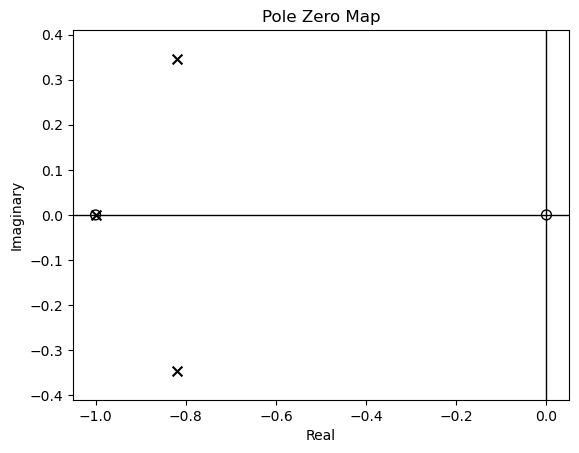

In [30]:
ct.pzmap(inv_pend_CL_U)

#### 4.3 - Resposta em frequência via diagramas de Bode

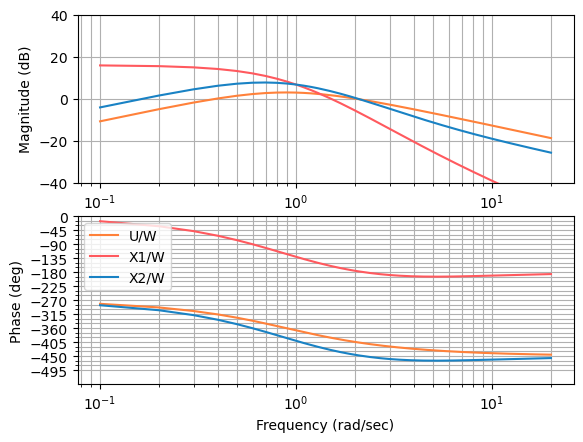

In [31]:
plt.figure()

magU, phaseU, omegaU = ct.bode_plot(
    inv_pend_CL_U, omega=np.linspace(0.1, 20, 201), color=cp['orange'], dB=True)
magX1, phaseX1, omegaX1 = ct.bode_plot(
    inv_pend_CL_X1, omega=np.linspace(0.1, 20, 201), color=cp['red'], dB=True)
magX2, phaseX2, omegaX2 = ct.bode_plot(
    inv_pend_CL_X2, omega=np.linspace(0.1, 20, 201), color=cp['blue'], dB=True)

mag_ax = plt.subplot(2, 1, 1)  # magnitude plot
phase_ax = plt.subplot(2, 1, 2)  # phase plot

mag_ax.set_ylim([-40, 40])  # y-limits (magnitude plot)
phase_ax.set_ylim([-540, 0])  # y-limits (phase plot)
plt.legend(["U/W", "X1/W", "X2/W"])

#### 4.4 - Simulação do sistema controlado

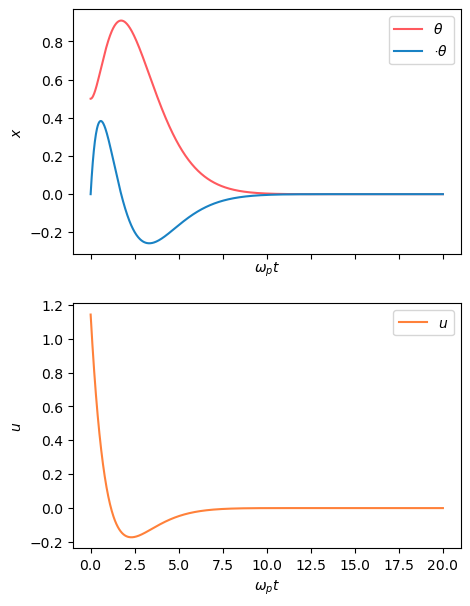

In [32]:
ts = np.linspace(0, 20, 1001)
w = np.linspace(0.1, 0.1, 1001)
x0 = [0.5, 0.0, 0.0]
t, u, x = ct.forced_response(inv_pend_CL_U, U=0, T=ts, X0=x0, return_x=True)

fig, (state, control_input) = plt.subplots(
    2, 1, figsize=(5, 7), sharex=True)

state.plot(t, x[0, :], color=cp['red'], label=r'$\theta$')
state.plot(t, x[1, :], color=cp['blue'], label=r'$\dot \theta$')
# state.plot(t, x[:, 2], color='black', label=r'$x_3$')
state.set_ylabel(r'$x$')
state.set_xlabel(r'$ω_p t$')
state.legend()

control_input.plot(t, u, color=cp['orange'], label=r'$u$')
control_input.set_ylabel(r'$u$')
control_input.set_xlabel(r'$ω_p t$')
control_input.legend()

### 5 - Observador de ordem reduzida

Em primeiro lugar, criaremos um sistema fictício com matriz de estados $A_{22}^\top$ e matriz de entradas de controle $A_{12}^\top$ para o qual usaremos o método da alocação de polos para obter a matriz J.

In [33]:
J = (ct.place(A22.T, A12.T, [-1.5-1.5j, -1.5+1.5j])).T
J

array([[ 3. ],
       [-4.5]])

Defininindo as matrizes $F$, $G$, $H$ e $S$:

In [34]:
F = A22 - J @ A12
G = A21  - J @ A11 + F @ J
H = B2 - J @ B1
S = M + N @ J

In [35]:
F

array([[-3. , -1. ],
       [ 4.5,  0. ]])

In [36]:
# autovalores e autovetores da dinâmica do erro em MF
la.eig(F)

(array([-1.5+1.5j, -1.5-1.5j]),
 array([[-0.30151134+0.30151134j, -0.30151134-0.30151134j],
        [ 0.90453403+0.j        ,  0.90453403-0.j        ]]))

In [37]:
S

array([[ 1. ],
       [ 3. ],
       [-4.5]])

Colocando o sistema na forma de espaço de estados:

\begin{align*}
    \frac{\mathrm{d}}{\mathrm{d}t}
    \begin{bmatrix}
        x(t) \\ z(t)
    \end{bmatrix}
    = 
    \begin{bmatrix}
        A & 0 \\ GC & F
    \end{bmatrix}
    \begin{bmatrix}
        x(t) \\ z(t)
    \end{bmatrix}
    +
    \begin{bmatrix}
        B \\ H
    \end{bmatrix}
    u(t)
\end{align*}

In [38]:
Aa = np.block([[A, np.zeros((n, n-m))], 
          [G @ C, F]])
Aa

array([[ 0. ,  1. ,  0. ,  0. ,  0. ],
       [ 1. ,  0. , -1. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ],
       [-3.5,  0. ,  0. , -3. , -1. ],
       [13.5,  0. ,  0. ,  4.5,  0. ]])

In [39]:
Ba = np.block([[B], [H]])
Ba

array([[0. ],
       [1. ],
       [2.5],
       [1. ],
       [2.5]])

In [40]:
Ea = np.block([[E], [np.zeros((n-m, l))]])
Ea

array([[0.],
       [1.],
       [0.],
       [0.],
       [0.]])

In [41]:
Ca = np.block([[C, np.zeros((m, n-m))]])
Ca

array([[1., 0., 0., 0., 0.]])

### 6 - Resposta do sistema em malha fechada (controlador + observador)

Adotando a lei de controle:
\begin{align*}
    u(t) = - K \hat x(t) = - K \begin{bmatrix}
        SC & N
    \end{bmatrix}
    \begin{bmatrix}
        x(t) \\ z(t)
    \end{bmatrix}
\end{align*}
pode-se estabelecer a dinâmica do sistema aumentado em malha-fechada:

In [42]:
Aa_c = Aa - Ba @ K @ np.block([S @ C, N])
Aa_c

array([[ 0.        ,  1.        ,  0.        ,  0.        ,  0.        ],
       [19.00223902,  0.        , -1.        ,  2.28532517, -1.96909741],
       [45.00559754,  0.        ,  0.        ,  5.71331293, -4.92274352],
       [14.50223902,  0.        ,  0.        , -0.71467483, -2.96909741],
       [58.50559754,  0.        ,  0.        , 10.21331293, -4.92274352]])

In [43]:
# polos em MF
la.eigvals(Aa_c)

array([-1.5       +1.5j       , -1.5       -1.5j       ,
       -1.        +0.j        , -0.81870917+0.34682086j,
       -0.81870917-0.34682086j])

In [44]:
inv_pend_CO_U = ct.ss(Aa_c, Ea, -K @ np.block([S @ C, N]), [[0]])
inv_pend_CO_X1 = ct.ss(Aa_c, Ea, np.array([[1, 0, 0, 0, 0]]), [[0]])
inv_pend_CO_X2 = ct.ss(Aa_c, Ea, np.array([[0, 1, 0, 0, 0]]), [[0]])

In [45]:
inv_pend_CO_U

<LinearIOSystem:sys[9]:['u[0]']->['y[0]']>

#### 6.1 - Polos e zeros

(array([-1.5       +1.5j       , -1.5       -1.5j       ,
        -1.        +0.j        , -0.81870917+0.34682086j,
        -0.81870917-0.34682086j]),
 array([-7.51593999e-29+0.j, -7.90471089e-02+0.j, -1.00000000e+00+0.j]))

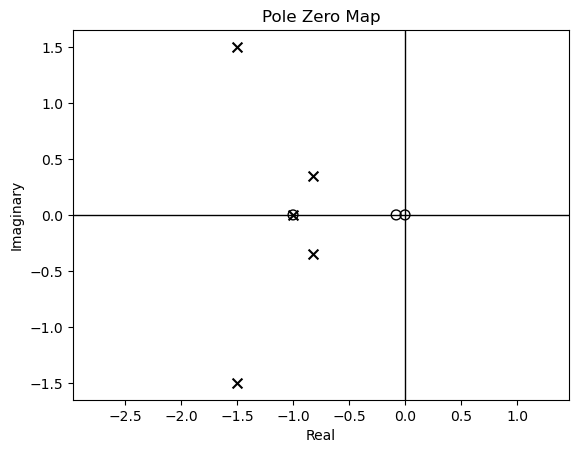

In [46]:
ct.pzmap(inv_pend_CO_U)

#### 6.2 - Resposta em frequência via diagramas de Bode

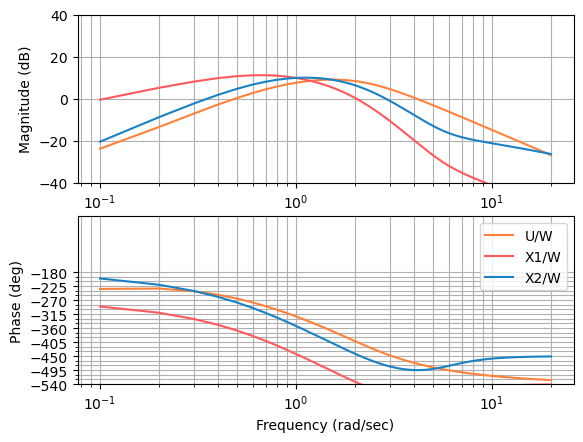

In [47]:
plt.figure()

magU, phaseU, omegaU = ct.bode_plot(
    inv_pend_CO_U, omega=np.linspace(0.1, 20, 201), color=cp['orange'], dB=True)
magX1, phaseX1, omegaX1 = ct.bode_plot(
    inv_pend_CO_X1, omega=np.linspace(0.1, 20, 201), color=cp['red'], dB=True)
magX2, phaseX2, omegaX2 = ct.bode_plot(
    inv_pend_CO_X2, omega=np.linspace(0.1, 20, 201), color=cp['blue'], dB=True)

mag_ax = plt.subplot(2, 1, 1)  # magnitude plot
phase_ax = plt.subplot(2, 1, 2)  # phase plot

mag_ax.set_ylim([-40, 40])  # y-limits (magnitude plot)
phase_ax.set_ylim([-540, 0])  # y-limits (phase plot)
plt.legend(["U/W", "X1/W", "X2/W"])

#### 6.3 - Simulação numérica do sistema

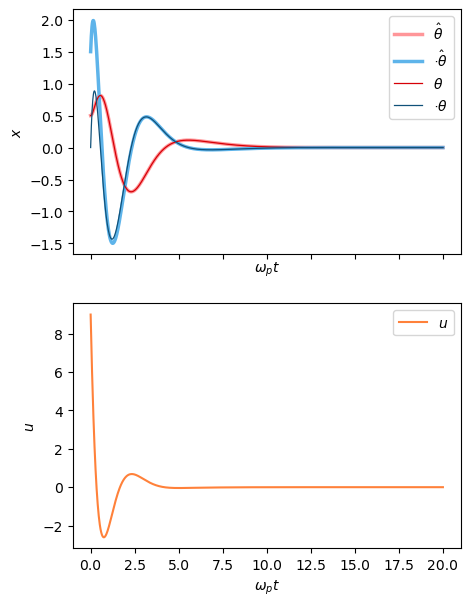

In [48]:
ts = np.linspace(0, 20, 1001)
w = np.linspace(0.1, 0.1, 1001)
x0 = [0.5, 0.0, 0.0, 0.0, 0.0]
t, u, x = ct.forced_response(inv_pend_CO_U, U=0, T=ts, X0=x0, return_x=True)
xe = S @ C @ x[0:n, :] + N @ x[n:, :]

fig, (state, control_input) = plt.subplots(
    2, 1, figsize=(5, 7), sharex=True)

state.plot(t, xe[0, :], linewidth=2.5, color=cp['lred'],
           label=r'$\hat{\theta}$')
state.plot(t, xe[1, :], linewidth=2.5, color=cp['lblue'],
           label=r'$\hat{\dot \theta}$')
state.plot(t, x[0, :], linewidth=0.9, color=cp['dred'], 
           label=r'$\theta$')
state.plot(t, x[1, :], linewidth=0.9, color=cp['dblue'], 
           label=r'$\dot \theta$')
state.set_ylabel(r'$x$')
state.set_xlabel(r'$ω_p t$')
state.legend()

control_input.plot(t, u, color=cp['orange'], label=r'$u$')
control_input.set_ylabel(r'$u$')
control_input.set_xlabel(r'$ω_p t$')
control_input.legend()